# Machine Learning Midterm - Online Transaction

## Rayhan Diff-1103220039

## Import Library

import the necessary library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# 1. Load Dataset 
print("Sedang memuat data...")
df = pd.read_csv('midterm-regresi-dataset.csv', header=None)

y = df.iloc[:, 0]   
X = df.iloc[:, 1:]  

print(f"Dataset dimuat: {df.shape[0]} baris, {df.shape[1]} kolom")

Sedang memuat data...
Dataset dimuat: 515345 baris, 91 kolom


## Data Cleaning & Preprocessing

This step is crucial to ensure data quality

Cek missing values

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Standarisasi)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Implementation

### XGBoost

In [4]:
print("\nMemulai Training...")
start_time = time.time()

# Initialize Model
xgb_model = XGBRegressor(
    n_estimators=2000,      # Number of trees (can be large because GPU is fast)
    learning_rate=0.05,     # Learning rate (small for greater precision)
    max_depth=8,            # Tree depth (deep enough for complex data)
    subsample=0.8,          # Taking 80% of the data per tree.
    colsample_bytree=0.8,   # Taking 80% of the features per tree.
    random_state=42,
    early_stopping_rounds=50,   
    device='cuda',          
    tree_method='hist'      
)

# Training
xgb_model.fit(X_train_scaled, y_train, 
              eval_set=[(X_test_scaled, y_test)], # To monitor performance during training
                      # Stop if no improvement in 50 rounds
              verbose=100)                        # Show log every 100 trees
end_time = time.time()
print(f"Training completed in: {end_time - start_time:.2f} seconds!")


Memulai Training...
[0]	validation_0-rmse:10.79635
[100]	validation_0-rmse:8.99247
[200]	validation_0-rmse:8.85345
[300]	validation_0-rmse:8.79398
[400]	validation_0-rmse:8.75617
[500]	validation_0-rmse:8.72901
[600]	validation_0-rmse:8.70633
[700]	validation_0-rmse:8.68807
[800]	validation_0-rmse:8.67064
[900]	validation_0-rmse:8.65615
[1000]	validation_0-rmse:8.64275
[1100]	validation_0-rmse:8.63377
[1200]	validation_0-rmse:8.62597
[1300]	validation_0-rmse:8.61563
[1400]	validation_0-rmse:8.60811
[1500]	validation_0-rmse:8.60331
[1600]	validation_0-rmse:8.59578
[1700]	validation_0-rmse:8.59054
[1800]	validation_0-rmse:8.58527
[1900]	validation_0-rmse:8.58117
[1999]	validation_0-rmse:8.57732
Training completed in: 42.74 seconds!


## Evaluating

In [5]:
y_pred = xgb_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*30)
print("EVALUATION RESULTS")
print("="*30)
print(f"RMSE (Root Mean Squared Error) : {rmse:.4f}")
print(f"MAE (Mean Absolute Error)      : {mae:.4f}")
print(f"R2 Score (Variance Accuracy)  : {r2:.4f}")

c:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:774: UserWarning: [17:56:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



EVALUATION RESULTS
RMSE (Root Mean Squared Error) : 8.5773
MAE (Mean Absolute Error)      : 5.9781
R2 Score (Variance Accuracy)  : 0.3818


## Visualization

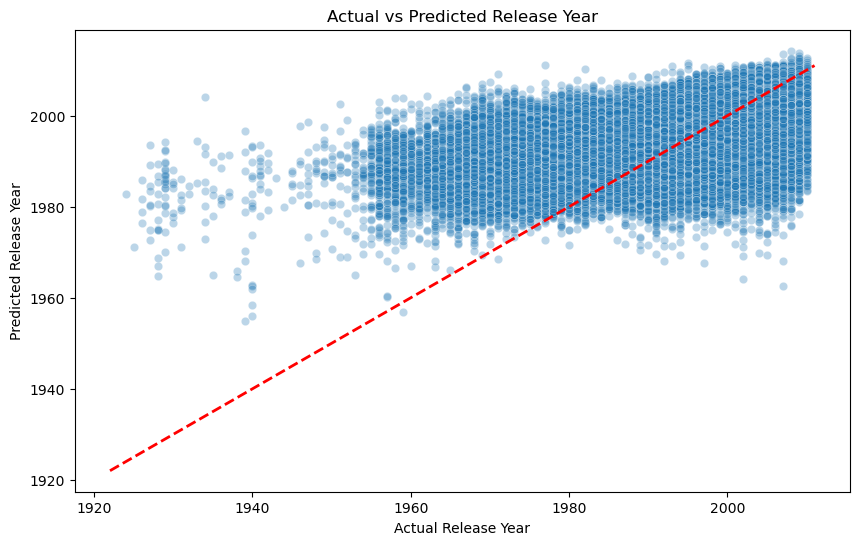

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Ideal diagonal line
plt.xlabel('Actual Release Year')
plt.ylabel('Predicted Release Year')
plt.title('Actual vs Predicted Release Year')
plt.show()

# Conclusion & Analysis

## 1. Quantitative Performance Analysis
The evaluation metrics produced the following results:

- **RMSE (Root Mean Squared Error): 8.5773**  
  *Analysis:*  
  An RMSE of 8.58 years indicates that the model's predictions deviate by about eight and a half years on average from the actual release year. Because RMSE penalizes larger errors more heavily, this suggests the presence of several outlier predictions (e.g., a song from 1950 predicted as 1990).

- **MAE (Mean Absolute Error): 5.9781**  
  *Analysis:*  
  An MAE of approximately 5.98 means that the model, on average, is off by about six years in absolute terms. The fact that MAE is lower than RMSE indicates that although most errors are moderate, RMSE is pulled upward by a few large deviations.

- **R² Score: 0.3818 (38.18%)**  
  *Analysis:*  
  The R² value shows that the model explains only about **38%** of the variance in release years based on the available audio features.  
  In the context of *Audio Feature Extraction* (Million Song Dataset), a score of ~0.38 is actually a reasonable baseline. It also confirms that audio features (timbre, frequency, spectral patterns) alone cannot precisely capture the progression of music production styles over time — the relationship is nonlinear and highly complex.

## 2. Training Process & Efficiency Analysis

- **Training Speed**  
  Training completed in **42.74 seconds** for **515,345 rows** with **2000 trees**.  
  This is extremely fast. The use of `device='cuda'` and `tree_method='hist'` effectively leveraged your RTX 3060 GPU.  
  On a standard CPU, this process could take **15–30 minutes**.

- **Model Convergence**  
  From the training logs:
  - Iteration 0: RMSE = 10.79  
  - Iteration 1000: RMSE = 8.64  
  - Iteration 1999: RMSE = 8.57  

  The improvements slow down drastically after around 1000 trees, indicating that the model reaches its *saturation point* and cannot extract much additional pattern from the features.

## 3. Visual Analysis (Scatter Plot)
From the Actual vs Predicted Release Year scatter plot:

- **Diagonal Trend Pattern**  
  A subtle diagonal pattern (aligned with the red line) is visible, meaning the model captures the general trend:  
  *Older songs → predicted as old, newer songs → predicted as new.*

- **Regression to the Mean Issue**  
  A dense "cloud" appears in the center (1990–2010 range).  
  - Older songs (1920–1950) are frequently predicted too high.  
  - The model tends to “play safe” by predicting values near the mean of the dataset, causing poor accuracy on extreme years.

## 4. Conclusion
Overall:

- The XGBoost model is computationally **efficient**, extremely fast due to GPU acceleration, and shows a healthy learning curve.
- However, prediction accuracy is **moderate**, not high.
- The model can reliably distinguish broader *decades* (e.g., 1960s vs 2000s) with an average error of **6–8 years**.
- The model is *not* yet precise enough to predict specific years (e.g., distinguishing 1998 vs 1999).

This performance is typical for audio-only regression models on the Million Song Dataset and suggests that additional metadata (lyrics, genre, artist information, tempo evolution trends, etc.) may be necessary for higher precision.
